In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, ShuffleSplit, LeaveOneOut
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,roc_auc_score,balanced_accuracy_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from matplotlib.colors import ListedColormap
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import f1_score
import pickle



### Reading Data

In [2]:
df = pd.read_csv('processedData.csv', index_col=[0])
df

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,marital_divorced,marital_married,marital_single
0,5,261,1,3,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
1,5,149,1,3,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
2,3,226,1,3,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
3,3,151,1,3,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
4,5,307,1,3,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,5,334,1,3,0,-1.1,94.767,-50.8,1.028,4963.6,...,0,0,0,0,1,0,0,0,1,0
41184,4,383,1,3,0,-1.1,94.767,-50.8,1.028,4963.6,...,0,0,0,0,1,0,0,0,1,0
41185,5,189,2,3,0,-1.1,94.767,-50.8,1.028,4963.6,...,0,0,0,0,1,0,0,0,1,0
41186,4,442,1,3,0,-1.1,94.767,-50.8,1.028,4963.6,...,0,0,0,0,1,0,0,0,1,0


In [3]:
def converty(x):
    if x=='yes':
        return 1
    return 0

y = df['y']
y = y.apply(converty)
X = df.drop(columns=['y'])

### Splitting data into test and train

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 17)

### SMOTE Oversampled data

In [5]:
# Create an oversampled training data
smote = SMOTE(random_state = 17)
X_SMOTE, y_SMOTE = smote.fit_resample(X_train, y_train)

***

### Classification Report Plot function

In [6]:
def plot_classification_report(cr, title='Classification report ', with_avg_total=False, cmap=plt.cm.summer):
    title = title or 'Classification report'
    lines = cr.split('\n')
    classes = []
    matrix = []

    for line in lines[2:(len(lines)-4)]:
        s = line.split()
        classes.append(s[0])
        value = [float(x) for x in s[1: len(s) - 1]]
        matrix.append(value)

    fig, ax = plt.subplots(1)

    for column in range(len(matrix)+1):
        for row in range(len(classes)):
            txt = matrix[row][column]
            ax.text(column,row,matrix[row][column],va='center',ha='center')

    fig = plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(len(classes)+1)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.ylabel('Classes')
    plt.xlabel('Measures')
    plt.show()

### ROC Curve plot function

In [7]:
def ROC_function(model,X_test,y_test):
    noskill_probs = [0 for _ in range(len(y_test))]

    # predict probabilities
    prob = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    prob = prob[:, 1]
    # calculate scores
    noskill_auc = roc_auc_score(y_test, noskill_probs)
    auc = roc_auc_score(y_test, prob)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (noskill_auc))
    print('RF: ROC AUC=%.3f' % (auc))
    # calculate roc curves
    noskill_fpr, noskill_tpr, _ = roc_curve(y_test, noskill_probs)
    fpr, tpr, _ = roc_curve(y_test, prob)
    # plot the roc curve for the model
    plt.figure(figsize=(16,8))
    plt.plot(noskill_fpr, noskill_tpr, linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='RF')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

***

### PCA (projects data on lower dimension)

In [8]:
pca = PCA(n_components=21)
X_pca_train = pca.fit_transform(X_train)
X_pca_test = pca.transform(X_test)

In [9]:
X_pca_train

array([[-1.79284440e+02, -5.88994120e+01,  4.05664140e+00, ...,
         1.87862759e-01, -4.56456786e-01, -2.04686258e-01],
       [-2.39710350e+02,  7.09980011e+01, -6.21989223e+00, ...,
        -1.25580161e-01, -3.21079480e-01,  7.52160181e-01],
       [-1.67285395e+02, -5.90451730e+01,  4.07816785e+00, ...,
         9.92475715e-02, -5.98152685e-01, -1.41744335e-01],
       ...,
       [-5.07228690e+01,  6.87076198e+01, -5.25330265e+00, ...,
        -2.58940232e-01,  1.97803247e-01, -3.67575464e-01],
       [-1.89712611e+02,  7.03924404e+01, -5.25563609e+00, ...,
         8.50168076e-01,  3.21431737e-01, -3.19691324e-01],
       [-1.87284014e+02, -5.87764940e+01, -1.71414743e+00, ...,
        -5.46495797e-01, -1.89518271e-01, -2.79600695e-01]])

In [10]:
X_pca_test

array([[ 1.15404127e+00, -2.39969258e+01,  4.06677306e+00, ...,
        -2.89138010e-01, -1.42437920e-01,  1.93193406e-01],
       [-2.14282616e+02, -5.84772025e+01,  3.98781814e+00, ...,
         9.51989309e-01, -4.83264409e-01, -2.24840207e-02],
       [-1.72283380e+02, -5.89345603e+01, -2.62910831e+00, ...,
         1.24594094e-02, -2.37751545e-01,  1.10250674e-01],
       ...,
       [-2.36279689e+02, -5.81731645e+01, -1.67229806e+00, ...,
        -1.61454827e-01, -6.11158577e-02,  3.31939473e-01],
       [ 1.09255096e+02,  1.48264272e+02,  1.13113952e+01, ...,
        -2.53627885e-01,  2.61579523e-01,  6.80888137e-01],
       [ 1.34692739e+02, -6.26869918e+01, -1.62400815e+00, ...,
         6.91884717e-01, -3.42612057e-01, -1.99474889e-01]])

### PCA on SMOTE Oversampled Data

In [11]:
pca = PCA(n_components=21)
X_smote_pca_train = pca.fit_transform(X_SMOTE)
X_smote_pca_test = pca.transform(X_test)

***

## Logistic Regression

* ### Logistic Regression on PCA data

In [12]:
lr_model = LogisticRegression(solver='lbfgs', max_iter=500)
lr_model.fit(X_pca_train, y_train)

LogisticRegression(max_iter=500)

In [13]:
y_pred = lr_model.predict(X_pca_test)

In [14]:
lr_acc = round(metrics.accuracy_score(y_test, y_pred)*100, 2)
lr_bacc = round(metrics.balanced_accuracy_score(y_test, y_pred)*100, 2)

print(f"Accuracy: {lr_acc}%")
print(f"Balanced Accuracy: {lr_bacc}%")

Accuracy: 90.22%
Balanced Accuracy: 66.64%


In [15]:
lr_classification_report = classification_report(y_test, y_pred)
print(lr_classification_report)

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      7303
           1       0.62      0.36      0.46       932

    accuracy                           0.90      8235
   macro avg       0.77      0.67      0.70      8235
weighted avg       0.89      0.90      0.89      8235



In [16]:
lr_pca_cm = confusion_matrix(y_test, y_pred)
print(lr_pca_cm)

[[7093  210]
 [ 595  337]]


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

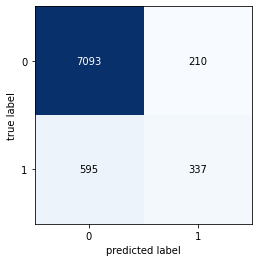

In [17]:
plot_confusion_matrix(lr_pca_cm)

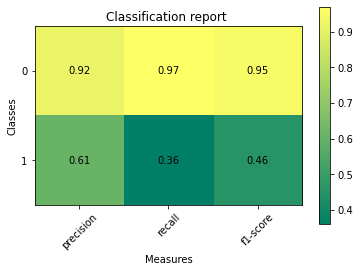

In [21]:
lr_pca_cr = """ precision    recall  f1-score   support

           0       0.92      0.97      0.95      7303
           1       0.61      0.36      0.46       932

    accuracy                           0.90      8235
   macro avg       0.77      0.67      0.70      8235
weighted avg       0.89      0.90      0.89      8235"""

plot_classification_report(lr_pca_cr)

In [18]:
lr_pca_f1 = f1_score(y_test, y_pred, average=None)
lr_pca_f1

array([0.94630111, 0.45571332])

#### ROC Curve:

No Skill: ROC AUC=0.500
RF: ROC AUC=0.927


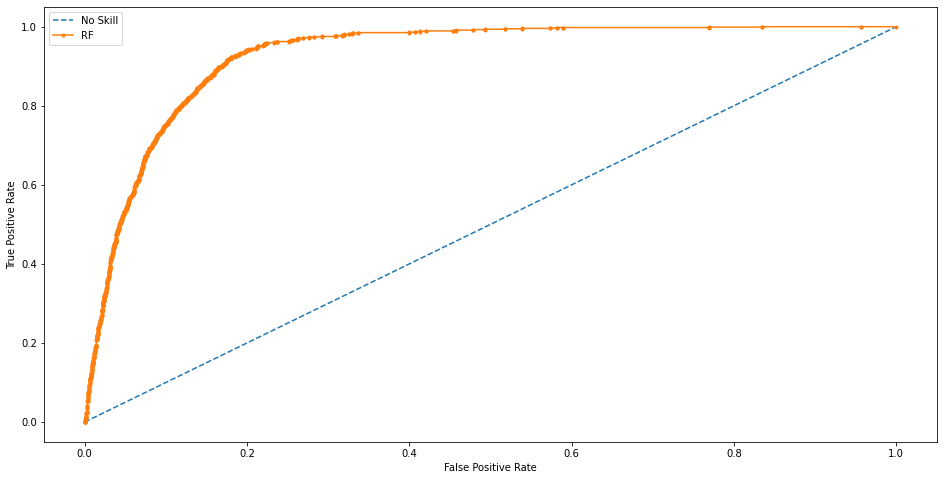

In [19]:
ROC_function(lr_model, X_pca_test, y_test)

* ### Logistic Regression on SMOTE PCA Data

In [20]:
lrsmote_model = LogisticRegression(solver='lbfgs', max_iter=500)
lrsmote_model.fit(X_smote_pca_train, y_SMOTE)

/home/prastogi/anaconda3/envs/my_env_py/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(max_iter=500)

In [21]:
y_pred_SMOTE = lrsmote_model.predict(X_smote_pca_test)

In [22]:
lrsmote_acc = round(metrics.accuracy_score(y_test, y_pred_SMOTE)*100, 2)
lrsmote_bacc = round(metrics.balanced_accuracy_score(y_test, y_pred_SMOTE)*100, 2)

print(f"Accuracy: {lrsmote_acc}%")
print(f"Balanced Accuracy: {lrsmote_bacc}%")

Accuracy: 88.72%
Balanced Accuracy: 75.2%


In [23]:
lrsmote_classification_report = classification_report(y_test, y_pred_SMOTE)
print(lrsmote_classification_report)

              precision    recall  f1-score   support

           0       0.94      0.93      0.94      7303
           1       0.50      0.58      0.54       932

    accuracy                           0.89      8235
   macro avg       0.72      0.75      0.74      8235
weighted avg       0.89      0.89      0.89      8235



In [24]:
lr_pca_smote_cm = confusion_matrix(y_test, y_pred_SMOTE)
print(lr_pca_smote_cm)

[[6768  535]
 [ 394  538]]


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

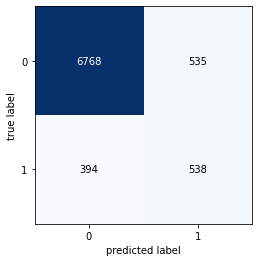

In [25]:
plot_confusion_matrix(lr_pca_smote_cm)

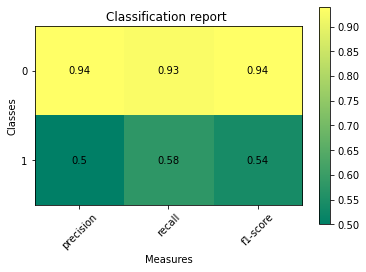

In [28]:
lr_pca_smote_cr = """ precision    recall  f1-score   support

           0       0.94      0.93      0.94      7303
           1       0.50      0.58      0.54       932

    accuracy                           0.89      8235
   macro avg       0.72      0.75      0.74      8235
weighted avg       0.89      0.89      0.89      8235"""

plot_classification_report(lr_pca_smote_cr)

In [26]:
lr_pca_smote_f1 = f1_score(y_test, y_pred_SMOTE, average=None)
lr_pca_smote_f1

array([0.93577601, 0.53665835])

#### ROC Curve:

No Skill: ROC AUC=0.500
RF: ROC AUC=0.901


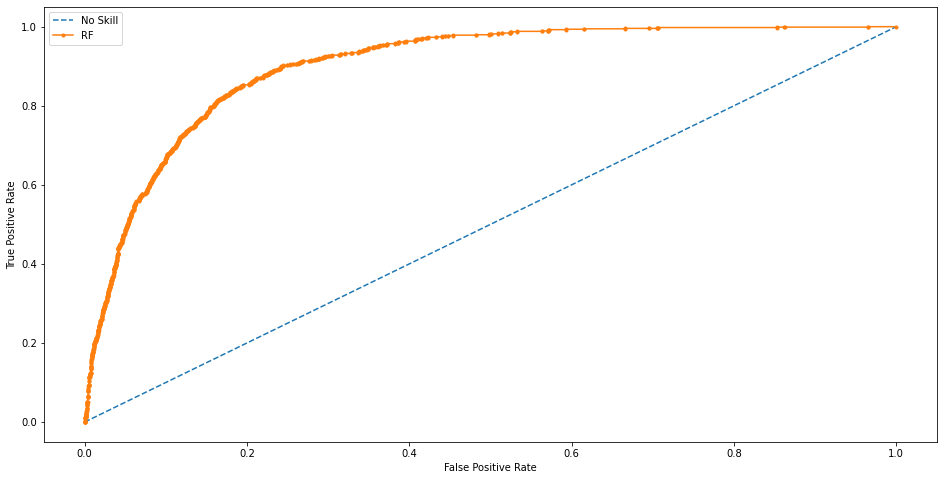

In [29]:
ROC_function(lrsmote_model, X_smote_pca_test, y_test)

***

## K-Nearest Neighbors

* ### KNN on PCA Imbalanced Data

In [30]:
knn_pca = make_pipeline(StandardScaler(), KNeighborsClassifier())
knn_pca.fit(X_pca_train, y_train)
knn_pca.score(X_pca_test, y_test)

0.8942319368548877

In [31]:
knn_pca_pred = knn_pca.predict(X_pca_test)

In [32]:
knn_pca_acc = round(metrics.accuracy_score(y_test, knn_pca_pred)*100, 2)
knn_pca_bacc = round(metrics.balanced_accuracy_score(y_test, knn_pca_pred)*100, 2)

print(f"Accuracy: {knn_pca_acc}%")
print(f"Balanced Accuracy: {knn_pca_bacc}%")

Accuracy: 89.42%
Balanced Accuracy: 64.36%


In [33]:
knn_pca_classification_report = classification_report(y_test, knn_pca_pred)
print(knn_pca_classification_report)

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      7303
           1       0.56      0.32      0.41       932

    accuracy                           0.89      8235
   macro avg       0.74      0.64      0.67      8235
weighted avg       0.88      0.89      0.88      8235



In [34]:
knn_pca_cm = confusion_matrix(y_test, knn_pca_pred)
print(knn_pca_cm)

[[7066  237]
 [ 634  298]]


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

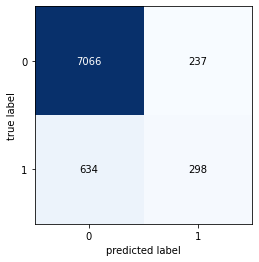

In [35]:
plot_confusion_matrix(knn_pca_cm)

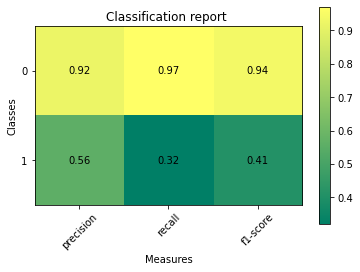

In [39]:
knn_pca_cr = """ precision    recall  f1-score   support

           0       0.92      0.97      0.94      7303
           1       0.56      0.32      0.41       932

    accuracy                           0.89      8235
   macro avg       0.74      0.64      0.67      8235
weighted avg       0.88      0.89      0.88      8235"""

plot_classification_report(knn_pca_cr)

In [36]:
knn_pca_f1 = f1_score(y_test, knn_pca_pred, average=None)
knn_pca_f1

array([0.94194494, 0.4062713 ])

#### ROC Curve:

No Skill: ROC AUC=0.500
RF: ROC AUC=0.836


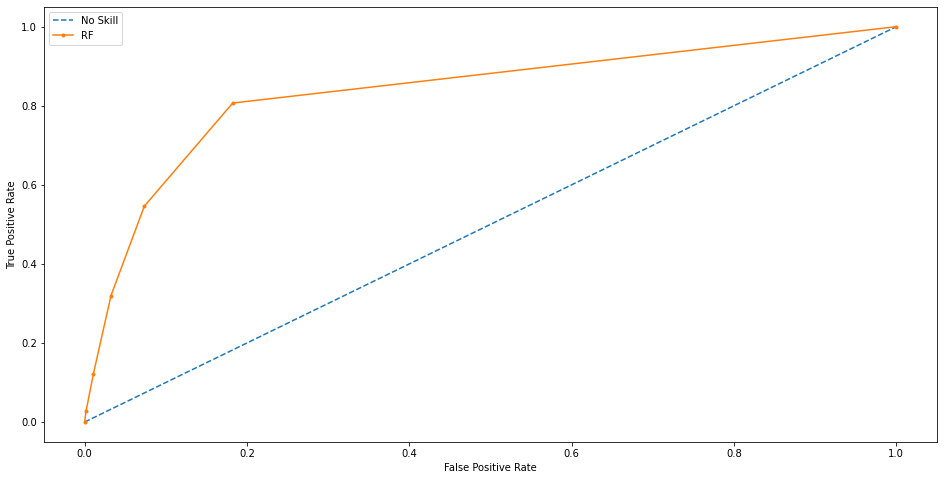

In [37]:
ROC_function(knn_pca, X_pca_test, y_test)

* ### KNN on PCA SMOTE Data

In [38]:
knn_smote = make_pipeline(StandardScaler(), KNeighborsClassifier())
knn_smote.fit(X_smote_pca_train, y_SMOTE)
knn_smote.score(X_smote_pca_test, y_test)

0.8864602307225258

In [39]:
knn_smote_pred = knn_smote.predict(X_smote_pca_test)

In [40]:
knn_smote_acc = round(metrics.accuracy_score(y_test, knn_smote_pred)*100, 2)
knn_smote_bacc = round(metrics.balanced_accuracy_score(y_test, knn_smote_pred)*100, 2)

print(f"Accuracy: {knn_smote_acc}%")
print(f"Balanced Accuracy: {knn_smote_bacc}%")

Accuracy: 88.65%
Balanced Accuracy: 68.51%


In [41]:
knn_smote_classification_report = classification_report(y_test, knn_smote_pred)
print(knn_smote_classification_report)

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      7303
           1       0.50      0.42      0.46       932

    accuracy                           0.89      8235
   macro avg       0.71      0.69      0.70      8235
weighted avg       0.88      0.89      0.88      8235



In [42]:
knn_smote_cm = confusion_matrix(y_test, knn_smote_pred)
print(knn_smote_cm)

[[6904  399]
 [ 536  396]]


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

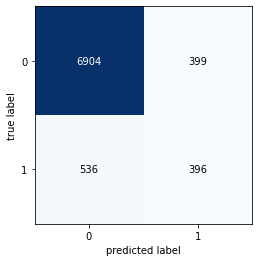

In [43]:
plot_confusion_matrix(knn_smote_cm)

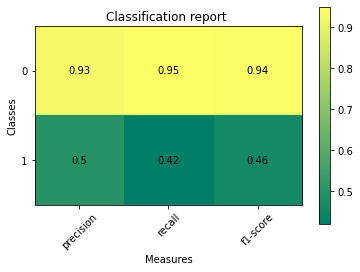

In [46]:
knn_smote_cr = """ precision    recall  f1-score   support

           0       0.93      0.95      0.94      7303
           1       0.50      0.42      0.46       932

    accuracy                           0.89      8235
   macro avg       0.71      0.69      0.70      8235
weighted avg       0.88      0.89      0.88      8235"""

plot_classification_report(knn_smote_cr)

In [44]:
knn_smote_f1 = f1_score(y_test, knn_smote_pred, average=None)
knn_smote_f1

array([0.93658007, 0.45859873])

#### ROC Curve:

No Skill: ROC AUC=0.500
RF: ROC AUC=0.818


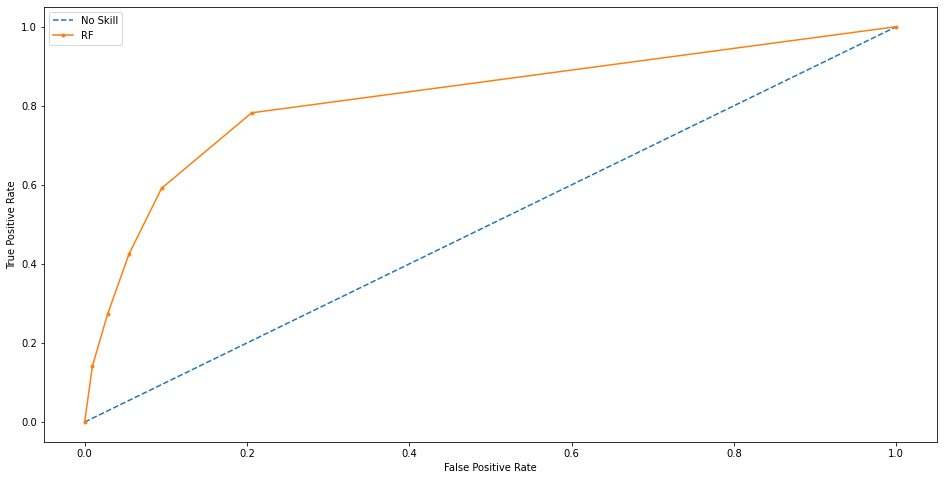

In [45]:
ROC_function(knn_smote, X_smote_pca_test, y_test)

***

## SVM Linear

* ### SVM Linear on PCA Imbalanced Data

In [94]:
svm_pca_model = make_pipeline(StandardScaler(), svm.SVC(kernel='linear'))
svm_pca_model.fit(X_pca_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(kernel='linear'))])

In [95]:
svm_pca_predictions = svm_pca_model.predict(X_pca_test)

In [96]:
svm_li_pca_acc = round(metrics.accuracy_score(y_test, svm_pca_predictions)*100, 2)
svm_li_pca_bacc = round(metrics.balanced_accuracy_score(y_test, svm_pca_predictions)*100, 2)

print(f"Accuracy: {svm_li_pca_acc}%")
print(f"Balanced Accuracy: {svm_li_pca_bacc}%")

Accuracy: 89.95%
Balanced Accuracy: 62.32%


In [97]:
svm_pca_cm = confusion_matrix(y_test, svm_pca_predictions)
print(svm_pca_cm)

[[7159  144]
 [ 684  248]]


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

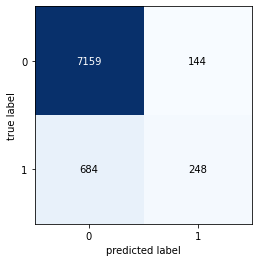

In [98]:
plot_confusion_matrix(svm_pca_cm)

In [99]:
svm_pca_classification_report = classification_report(y_test, svm_pca_predictions)
print(svm_pca_classification_report)

              precision    recall  f1-score   support

           0       0.91      0.98      0.95      7303
           1       0.63      0.27      0.37       932

    accuracy                           0.90      8235
   macro avg       0.77      0.62      0.66      8235
weighted avg       0.88      0.90      0.88      8235



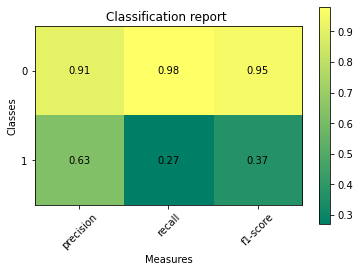

In [101]:
svm_pca_cr = """          precision    recall  f1-score   support

           0       0.91      0.98      0.95      7303
           1       0.63      0.27      0.37       932

    accuracy                           0.90      8235
   macro avg       0.77      0.62      0.66      8235
weighted avg       0.88      0.90      0.88      8235"""

plot_classification_report(svm_pca_cr)

In [100]:
svm_li_pca_f1 = f1_score(y_test, svm_pca_predictions, average=None)
svm_li_pca_f1

array([0.9453321 , 0.37462236])

* ### SVM Linear on SMOTE PCA Data

In [12]:
svm_smote = SVC(kernel='linear')
svm_smote.fit(X_smote_pca_train, y_SMOTE) 

SVC(kernel='linear')

In [13]:
filename = 'SavedModels/svm_li_SMOTE_PCA.pkl'
pickle.dump(svm_smote, open(filename, 'wb'))

In [14]:
# load the model from disk
svm_smote = pickle.load(open(filename, 'rb'))

In [15]:
svm_smote_predictions = svm_smote.predict(X_smote_pca_test)

In [16]:
svm_li_smote_acc = round(metrics.accuracy_score(y_test, svm_smote_predictions)*100, 2)
svm_li_smote_bacc = round(metrics.balanced_accuracy_score(y_test, svm_smote_predictions)*100, 2)

print(f"Accuracy: {svm_li_smote_acc}%")
print(f"Balanced Accuracy: {svm_li_smote_bacc}%")

Accuracy: 88.8%
Balanced Accuracy: 75.95%


In [17]:
svm_smote_cm = confusion_matrix(y_test, svm_smote_predictions)
print(svm_smote_cm)

[[6760  543]
 [ 379  553]]


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x195211c8bc8>)

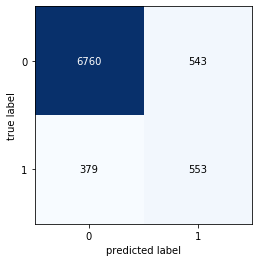

In [18]:
plot_confusion_matrix(svm_smote_cm)

In [19]:
svm_smote_classification_report = classification_report(y_test, svm_smote_predictions)
print(svm_smote_classification_report)

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      7303
           1       0.50      0.59      0.55       932

    accuracy                           0.89      8235
   macro avg       0.73      0.76      0.74      8235
weighted avg       0.90      0.89      0.89      8235



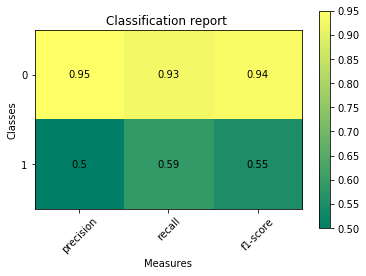

In [21]:
svm_smote_cr = """            precision    recall  f1-score   support

           0       0.95      0.93      0.94      7303
           1       0.50      0.59      0.55       932

    accuracy                           0.89      8235
   macro avg       0.73      0.76      0.74      8235
weighted avg       0.90      0.89      0.89      8235"""

plot_classification_report(svm_smote_cr)

In [22]:
svm_li_smote_f1 = f1_score(y_test, svm_smote_predictions, average=None)
svm_li_smote_f1

array([0.93615843, 0.54536489])

***

## SVM RBF

* ### SVM RBF on PCA Imbalanced Data

In [102]:
param_grid1 = {'C': [0.1,1, 10], 'gamma': [1,0.1,0.01],'kernel': ['rbf']}
svm_rbf_pca = GridSearchCV(SVC(),param_grid1,refit=True,verbose=2, n_jobs = -1)
svm_rbf_pca.fit(X_pca_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done  37 out of  45 | elapsed: 25.9min remaining:  5.6min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 28.3min finished


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['rbf']},
             verbose=2)

In [103]:
print(svm_rbf_pca.best_estimator_)

SVC(C=1, gamma=0.01)


In [104]:
svm_rbf_pca_predictions = svm_rbf_pca.predict(X_pca_test)

In [105]:
svm_rbf_pca_acc = round(metrics.accuracy_score(y_test, svm_rbf_pca_predictions)*100, 2)
svm_rbf_pca_bacc = round(metrics.balanced_accuracy_score(y_test, svm_rbf_pca_predictions)*100, 2)

print(f"Accuracy: {svm_rbf_pca_acc}%")
print(f"Balanced Accuracy: {svm_rbf_pca_bacc}%")

Accuracy: 90.49%
Balanced Accuracy: 69.23%


In [106]:
svm_rbf_pca_cm = confusion_matrix(y_test, svm_rbf_pca_predictions)
print(svm_rbf_pca_cm)

[[7063  240]
 [ 543  389]]


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

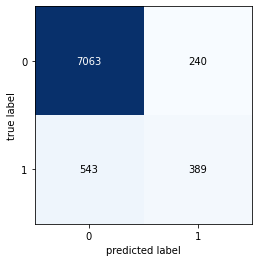

In [107]:
plot_confusion_matrix(svm_rbf_pca_cm)

In [108]:
svm_rbf_pca_classification_report = classification_report(y_test, svm_rbf_pca_predictions)
print(svm_rbf_pca_classification_report)

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7303
           1       0.62      0.42      0.50       932

    accuracy                           0.90      8235
   macro avg       0.77      0.69      0.72      8235
weighted avg       0.89      0.90      0.90      8235



In [ ]:
svm_rbf_pca_cr = """            precision    recall  f1-score   support

           0       0.93      0.97      0.95      7303
           1       0.62      0.42      0.50       932

    accuracy                           0.90      8235
   macro avg       0.77      0.69      0.72      8235
weighted avg       0.89      0.90      0.90      8235"""

plot_classification_report(svm_rbf_pca_cr)

In [109]:
svm_rbf_pca_f1 = f1_score(y_test, svm_rbf_pca_predictions, average=None)
svm_rbf_pca_f1

array([0.94748139, 0.49839846])

* ### SVM RBF on PCA SMOTE Data

In [85]:
svm_rbf_smote = make_pipeline(StandardScaler(), SVC(C=10, cache_size = 200, kernel = 'rbf', gamma = 0.01))
svm_rbf_smote.fit(X_smote_pca_train, y_SMOTE)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=10, gamma=0.01))])

In [86]:
svm_rbf_smote_predictions = svm_rbf_smote.predict(X_smote_pca_test)

In [88]:
svm_rbf_smote_acc = round(metrics.accuracy_score(y_test, svm_rbf_smote_predictions)*100, 2)
svm_rbf_smote_bacc = round(metrics.balanced_accuracy_score(y_test, svm_rbf_smote_predictions)*100, 2)

print(f"Accuracy: {svm_rbf_smote_acc}%")
print(f"Balanced Accuracy: {svm_rbf_smote_bacc}%")

Accuracy: 90.59%
Balanced Accuracy: 71.53%


In [89]:
svm_rbf_smote_cm = confusion_matrix(y_test, svm_rbf_smote_predictions)
print(svm_rbf_smote_cm)

[[7023  280]
 [ 495  437]]


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

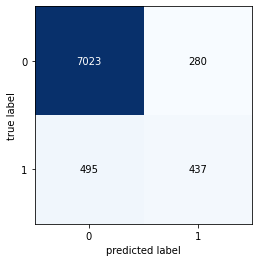

In [90]:
plot_confusion_matrix(svm_rbf_smote_cm)

In [91]:
svm_rbf_smote_classification_report = classification_report(y_test, svm_rbf_smote_predictions)
print(svm_rbf_smote_classification_report)

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      7303
           1       0.61      0.47      0.53       932

    accuracy                           0.91      8235
   macro avg       0.77      0.72      0.74      8235
weighted avg       0.90      0.91      0.90      8235



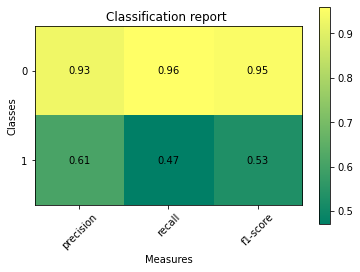

In [92]:
svm_rbf_smote_cr = """            precision    recall  f1-score   support

           0       0.93      0.96      0.95      7303
           1       0.61      0.47      0.53       932

    accuracy                           0.91      8235
   macro avg       0.77      0.72      0.74      8235
weighted avg       0.90      0.91      0.90      8235"""

plot_classification_report(svm_rbf_smote_cr)

In [93]:
svm_rbf_smote_f1 = f1_score(y_test, svm_rbf_smote_predictions, average=None)
svm_rbf_smote_f1

array([0.94770933, 0.53001819])

***

## Random Forest

* ### Random Forest on PCA Imbalanced Data

In [76]:
rf_pca_model = RandomForestClassifier(random_state=12)
rf_pca_model.fit(X_pca_train, y_train)

RandomForestClassifier(random_state=12)

In [77]:
rf_pred = rf_pca_model.predict(X_pca_test)

In [78]:
rf_pca_acc = round(metrics.accuracy_score(y_test, rf_pred)*100, 2)
rf_pca_bacc = round(metrics.balanced_accuracy_score(y_test, rf_pred)*100, 2)

print(f"Accuracy: {rf_pca_acc}%")
print(f"Balanced Accuracy: {rf_pca_bacc}%")

Accuracy: 91.04%
Balanced Accuracy: 72.11%


In [79]:
rf_pca_cm = confusion_matrix(y_test, rf_pred)
print(rf_pca_cm)


[[7053  250]
 [ 488  444]]


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

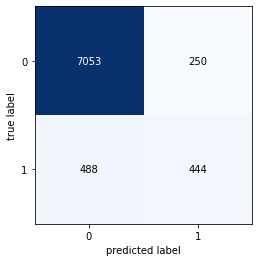

In [80]:
plot_confusion_matrix(rf_pca_cm)

In [81]:
rf_pca_classification_report = classification_report(y_test, rf_pred)
print(rf_pca_classification_report)

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      7303
           1       0.64      0.48      0.55       932

    accuracy                           0.91      8235
   macro avg       0.79      0.72      0.75      8235
weighted avg       0.90      0.91      0.90      8235



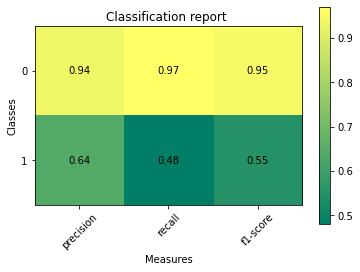

In [83]:
rf_pca_cr = """       precision    recall  f1-score   support

           0       0.94      0.97      0.95      7303
           1       0.64      0.48      0.55       932

    accuracy                           0.91      8235
   macro avg       0.79      0.72      0.75      8235
weighted avg       0.90      0.91      0.90      8235"""

plot_classification_report(rf_pca_cr)

In [82]:
rf_pca_f1 = f1_score(y_test, rf_pred, average=None)
rf_pca_f1

array([0.95028294, 0.54612546])

#### ROC Curve:

No Skill: ROC AUC=0.500
RF: ROC AUC=0.939


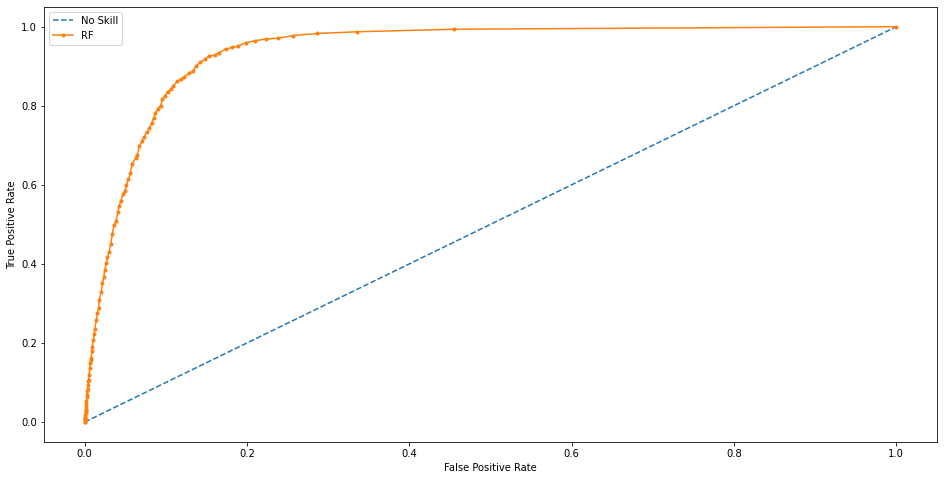

In [84]:
ROC_function(rf_pca_model, X_pca_test, y_test)

* ### Random Forest on PCA SMOTE Data

In [65]:
rf_smote = RandomForestClassifier(criterion = 'entropy', n_estimators = 100, max_depth = 8, max_features = 6, min_samples_leaf=2, random_state=12)
rf_smote.fit(X_smote_pca_train, y_SMOTE)

RandomForestClassifier(criterion='entropy', max_depth=8, max_features=6,
                       min_samples_leaf=2, random_state=12)

In [68]:
rf_smote_pred = rf_smote.predict(X_smote_pca_test)

In [69]:
rf_smote_acc = round(metrics.accuracy_score(y_test, rf_smote_pred)*100, 2)
rf_smote_bacc = round(metrics.balanced_accuracy_score(y_test, rf_smote_pred)*100, 2)

print(f"Accuracy: {rf_smote_acc}%")
print(f"Balanced Accuracy: {rf_smote_bacc}%")

Accuracy: 90.1%
Balanced Accuracy: 82.06%


In [70]:
rf_smote_cm = confusion_matrix(y_test, rf_smote_pred)
print(rf_smote_cm)

[[6752  551]
 [ 264  668]]


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

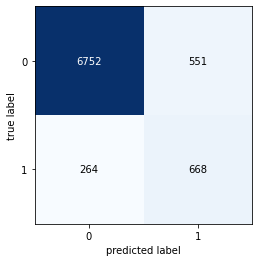

In [71]:
plot_confusion_matrix(rf_smote_cm)

In [72]:
rf_smote_classification_report = classification_report(y_test, rf_smote_pred)
print(rf_smote_classification_report)

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      7303
           1       0.55      0.72      0.62       932

    accuracy                           0.90      8235
   macro avg       0.76      0.82      0.78      8235
weighted avg       0.92      0.90      0.91      8235



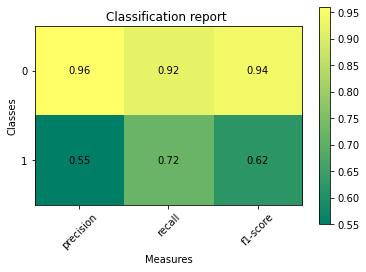

In [73]:
rf_smote_cr = """       precision    recall  f1-score   support

           0       0.96      0.92      0.94      7303
           1       0.55      0.72      0.62       932

    accuracy                           0.90      8235
   macro avg       0.76      0.82      0.78      8235
weighted avg       0.92      0.90      0.91      8235"""

plot_classification_report(rf_smote_cr)

In [74]:
rf_smote_f1 = f1_score(y_test, rf_smote_pred, average=None)
rf_smote_f1

array([0.94308262, 0.62110646])

#### ROC Curve:

No Skill: ROC AUC=0.500
RF: ROC AUC=0.938


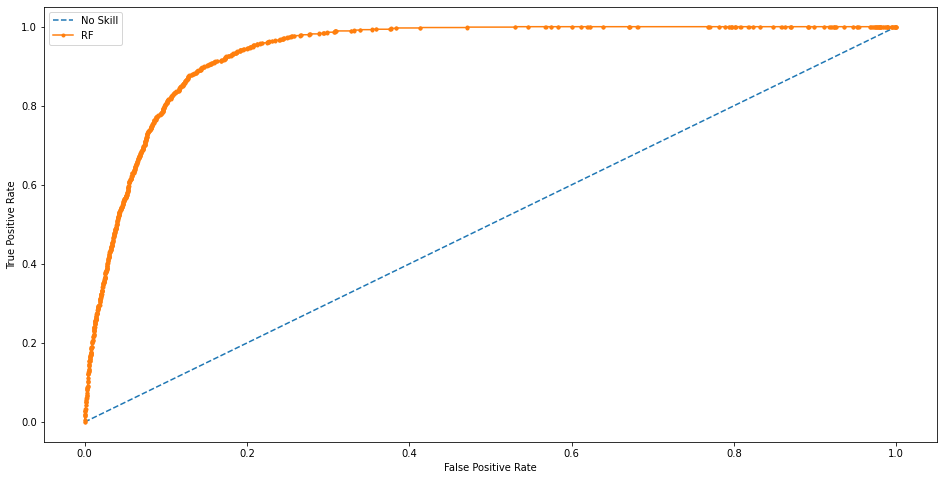

In [75]:
ROC_function(rf_smote, X_smote_pca_test, y_test)

***

## Gradient Boosting Machine

* ### GBM on PCA Imbalanced Data

In [56]:
gbm_pca = GradientBoostingClassifier(random_state = 12)
gbm_pca.fit(X_pca_train, y_train)

GradientBoostingClassifier(random_state=12)

In [57]:
gbm_pred = gbm_pca.predict(X_pca_test)

In [58]:
gbm_pca_acc = round(metrics.accuracy_score(y_test, gbm_pred)*100, 2)
gbm_pca_bacc = round(metrics.balanced_accuracy_score(y_test, gbm_pred)*100, 2)

print(f"Accuracy: {gbm_pca_acc}%")
print(f"Balanced Accuracy: {gbm_pca_bacc}%")

Accuracy: 91.01%
Balanced Accuracy: 73.03%


In [59]:
gbm_pca_cm = confusion_matrix(y_test, gbm_pred)
print(gbm_pca_cm)

[[7031  272]
 [ 468  464]]


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

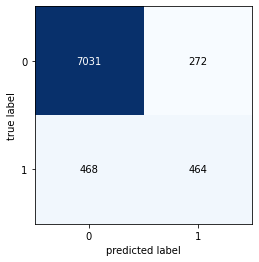

In [60]:
plot_confusion_matrix(gbm_pca_cm)

In [61]:
gbm_pca_classification_report = classification_report(y_test, gbm_pred)
print(gbm_pca_classification_report)

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      7303
           1       0.63      0.50      0.56       932

    accuracy                           0.91      8235
   macro avg       0.78      0.73      0.75      8235
weighted avg       0.90      0.91      0.91      8235



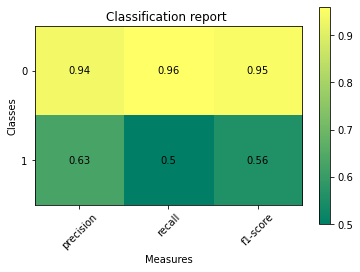

In [64]:
gbm_pca_cr = """       precision    recall  f1-score   support

           0       0.94      0.96      0.95      7303
           1       0.63      0.50      0.56       932

    accuracy                           0.91      8235
   macro avg       0.78      0.73      0.75      8235
weighted avg       0.90      0.91      0.91      8235"""

plot_classification_report(gbm_pca_cr)

In [62]:
gbm_pca_f1 = f1_score(y_test, gbm_pred, average=None)
gbm_pca_f1

array([0.95000676, 0.55635492])

#### ROC Curve:

No Skill: ROC AUC=0.500
RF: ROC AUC=0.943


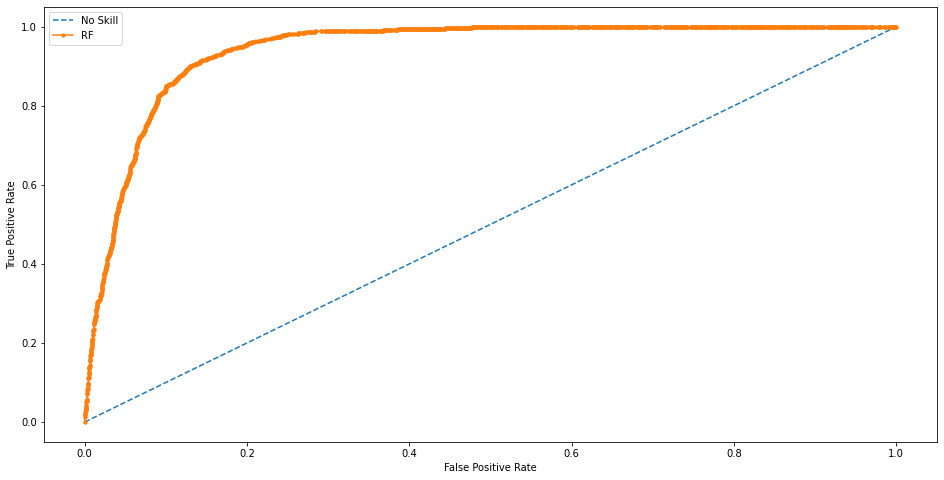

In [63]:
ROC_function(gbm_pca, X_pca_test, y_test)

* ### GBM on PCA SMOTE Data

In [47]:
gbm_smote = GradientBoostingClassifier(n_estimators=100, max_depth = 8, max_features = 7, min_samples_leaf = 1, random_state=12)
gbm_smote.fit(X_smote_pca_train, y_SMOTE)


GradientBoostingClassifier(max_depth=8, max_features=7, random_state=12)

In [48]:
gbm_smote_pred = gbm_smote.predict(X_smote_pca_test)

In [49]:
gbm_smote_acc = round(metrics.accuracy_score(y_test, gbm_smote_pred)*100, 2)
gbm_smote_bacc = round(metrics.balanced_accuracy_score(y_test, gbm_smote_pred)*100, 2)

print(f"Accuracy: {gbm_smote_acc}%")
print(f"Balanced Accuracy: {gbm_smote_bacc}%")

Accuracy: 90.47%
Balanced Accuracy: 76.28%


In [50]:
gbm_smote_cm = confusion_matrix(y_test, gbm_smote_pred)
print(gbm_smote_cm)

[[6910  393]
 [ 392  540]]


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

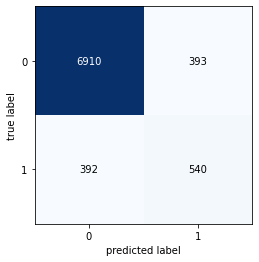

In [51]:
plot_confusion_matrix(gbm_smote_cm)

In [52]:
gbm_smote_classification_report = classification_report(y_test, gbm_smote_pred)
print(gbm_smote_classification_report)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      7303
           1       0.58      0.58      0.58       932

    accuracy                           0.90      8235
   macro avg       0.76      0.76      0.76      8235
weighted avg       0.90      0.90      0.90      8235



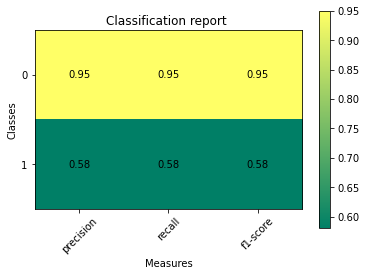

In [55]:
gbm_smote_cr = """       precision    recall  f1-score   support

           0       0.95      0.95      0.95      7303
           1       0.58      0.58      0.58       932

    accuracy                           0.90      8235
   macro avg       0.76      0.76      0.76      8235
weighted avg       0.90      0.90      0.90      8235"""

plot_classification_report(gbm_smote_cr)

In [53]:
gbm_smote_f1 = f1_score(y_test, gbm_smote_pred, average=None)
gbm_smote_f1

array([0.94625128, 0.57908847])

#### ROC Curve:

No Skill: ROC AUC=0.500
RF: ROC AUC=0.938


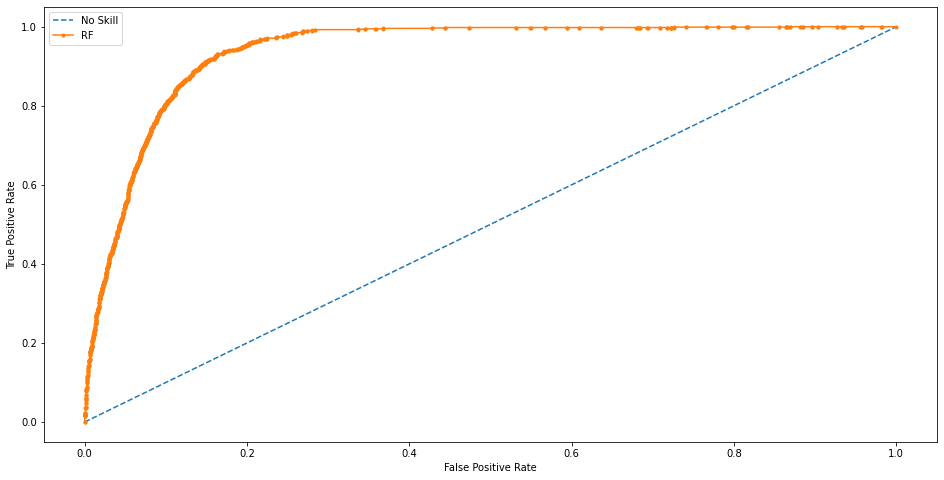

In [54]:
ROC_function(gbm_smote, X_smote_pca_test, y_test)

***

## References

* https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
* https://www.datacamp.com/community/tutorials/principal-component-analysis-in-python
* https://stackabuse.com/implementing-pca-in-python-with-scikit-learn/
